In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import skimage.io as io
import matplotlib.pyplot as plt

from src.utils.utils import plt_keypoints
from src.utils.preprocess import get_keypoints
from src.utils.nn import nn_base

In [3]:
train_df = pd.read_csv('./data/training.csv')
train_df['Image'] = train_df['Image'].apply(
    lambda row: np.reshape([float(num) for num in row.split(' ')], [96, 96, 1]))

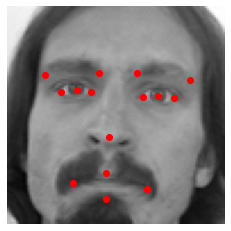

In [4]:
info = train_df.iloc[0]
keypt_xs = info[[cnm for cnm in info.index if '_x' in cnm]].values
keypt_ys = info[[cnm for cnm in info.index if '_y' in cnm]].values

plt.imshow(info['Image'], cmap = plt.cm.gray)
plt.scatter(keypt_xs, keypt_ys, color='r')
plt.axis('off')
plt.show()

### Data augmentation

In [22]:
import imgaug.augmenters as iaa
from imgaug.augmentables import Keypoint, KeypointsOnImage

In [6]:
data_df = pd.read_csv('./data/training.csv')
data_dict = get_keypoints(data_df, img_size=[96, 96])

In [163]:
for k in data_dict.keys():
    data_dict[k]['image'] = data_dict[k]['image'].tolist()

In [166]:
import json

In [167]:
with open('./data/tst.json', 'w') as f:
    json.dump(data_dict, f)

In [160]:
info = data_dict[0]

image = info['image'].astype(np.float32)
key_pts = KeypointsOnImage([
    Keypoint(info['left_eye']['center'][0], info['left_eye']['center'][1]),
    Keypoint(info['left_eye']['inner_corner'][0], info['left_eye']['inner_corner'][1]),
    Keypoint(info['left_eye']['outer_corner'][0], info['left_eye']['outer_corner'][1]),
    Keypoint(info['right_eye']['center'][0], info['right_eye']['center'][1]),
    Keypoint(info['right_eye']['inner_corner'][0], info['right_eye']['inner_corner'][1]),
    Keypoint(info['right_eye']['outer_corner'][0], info['right_eye']['outer_corner'][1]),
    Keypoint(info['left_eyebrow']['inner_end'][0], info['left_eyebrow']['inner_end'][1]),
    Keypoint(info['left_eyebrow']['outer_end'][0], info['left_eyebrow']['outer_end'][1]),
    Keypoint(info['right_eyebrow']['inner_end'][0], info['right_eyebrow']['inner_end'][1]),
    Keypoint(info['right_eyebrow']['outer_end'][0], info['right_eyebrow']['outer_end'][1]),
    Keypoint(info['mouth']['left_corner'][0], info['mouth']['left_corner'][1]),
    Keypoint(info['mouth']['right_corner'][0], info['mouth']['right_corner'][1]),
    Keypoint(info['mouth']['center_top_lip'][0], info['mouth']['center_top_lip'][1]),
    Keypoint(info['mouth']['center_bottom_lip'][0], info['mouth']['center_bottom_lip'][1]),
    Keypoint(info['nose']['tip'][0], info['nose']['tip'][1])
], shape=image.shape)

seq = iaa.Sequential([
    iaa.Multiply((0.5, 1.5)), # change brightness
    iaa.Affine(
        rotate=(0, 360),
        scale=(0.5, 1)), # rotate and scale, affects keypoints
])

# Augment keypoints and images.
image_aug, key_pts_aug = seq(image=I, keypoints=key_pts)

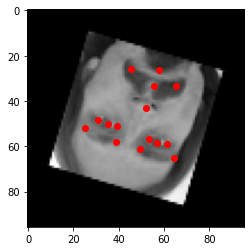

In [161]:
coords = key_pts_aug.get_coords_array()

plt.imshow(image_aug, cmap = plt.cm.gray)
plt.scatter(coords[:, 0], coords[:, 1], color='r')
plt.show()

### tf load data from local file

In [ ]:
# data_dir = './data/'

# tf.data.Dataset.list_files()

### base model

In [8]:
from tensorflow import keras

In [64]:
img_size = [96, 96, 1]

In [143]:
train_df_nonull = train_df.loc[train_df.isnull().sum(axis=1) == 0]

In [145]:
tf_input = np.stack(train_df_nonull['Image'].values)
tf_input.shape

(2140, 96, 96, 1)

In [146]:
tf_label = train_df_nonull.drop('Image', axis=1).values
labels = train_df_nonull.drop('Image', axis=1).columns

In [183]:
tf_label.shape

(2140, 30)

In [ ]:
nn_model = nn_base(img_size)
nn_model.compile(optimizer='Adam', loss='mse', metrics=['mae'])
nn_model.fit(tf_input, tf_label, batch_size=128, epochs=50, shuffle=True)

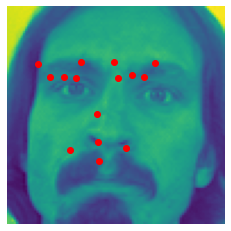

In [181]:
idx = 0

preds = nn_model.predict(tf_input[idx][np.newaxis, :])

preds_xs = preds[:, np.argwhere(['_x' in l for l in labels])]
preds_ys = preds[:, np.argwhere(['_y' in l for l in labels])]

plt.imshow(tf_input[idx])
plt.scatter(preds_xs[0], preds_ys[0], color='r')
plt.axis('off')
plt.show()

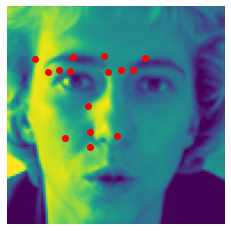

In [177]:
idx = 1

preds = nn_model.predict(tf_input[idx][np.newaxis, :])

preds_xs = preds[:, np.argwhere(['_x' in l for l in labels])]
preds_ys = preds[:, np.argwhere(['_y' in l for l in labels])]

plt.imshow(tf_input[idx])
plt.scatter(preds_xs[0], preds_ys[0], color='r')
plt.axis('off')
plt.show()

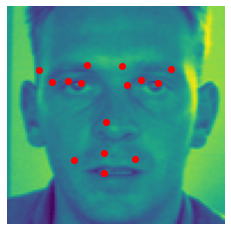

In [178]:
idx = 2

preds = nn_model.predict(tf_input[idx][np.newaxis, :])

preds_xs = preds[:, np.argwhere(['_x' in l for l in labels])]
preds_ys = preds[:, np.argwhere(['_y' in l for l in labels])]

plt.imshow(tf_input[idx])
plt.scatter(preds_xs[0], preds_ys[0], color='r')
plt.axis('off')
plt.show()

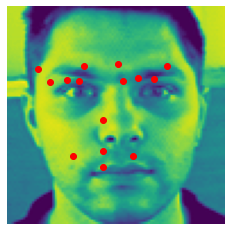

In [179]:
idx = 3

preds = nn_model.predict(tf_input[idx][np.newaxis, :])

preds_xs = preds[:, np.argwhere(['_x' in l for l in labels])]
preds_ys = preds[:, np.argwhere(['_y' in l for l in labels])]

plt.imshow(tf_input[idx])
plt.scatter(preds_xs[0], preds_ys[0], color='r')
plt.axis('off')
plt.show()

### cbl model

In [191]:
from src.utils.nn import nn_cbl

In [192]:
train_df_nonull = train_df.loc[train_df.isnull().sum(axis=1) == 0]
tf_input = np.stack(train_df_nonull['Image'].values)
print('Train input shape: {}'.format(tf_input.shape))

tf_label = train_df_nonull.drop('Image', axis=1).values
labels = train_df_nonull.drop('Image', axis=1).columns
print('Train label shape: {}'.format(tf_label.shape))

Train input shape: (2140, 96, 96, 1)
Train label shape: (2140, 30)


In [201]:
nn_model = nn_cbl(img_size, is_training=True)
nn_model.compile(optimizer='Adam', loss='mse', metrics=['mae'])
nn_model.fit(tf_input, tf_label, batch_size=128, epochs=50, shuffle=True)

Epoch 1/50
17/17 [==============================] - 12s 681ms/step - loss: 2577.6953 - mae: 47.1637
Epoch 2/50
17/17 [==============================] - 10s 579ms/step - loss: 2497.4275 - mae: 46.3187
Epoch 3/50
17/17 [==============================] - 9s 556ms/step - loss: 2409.7429 - mae: 45.3572
Epoch 4/50
17/17 [==============================] - 10s 568ms/step - loss: 2307.1289 - mae: 44.2018
Epoch 5/50
17/17 [==============================] - 10s 591ms/step - loss: 2192.3276 - mae: 42.8874
Epoch 6/50
17/17 [==============================] - 10s 567ms/step - loss: 2068.3176 - mae: 41.4261
Epoch 7/50
17/17 [==============================] - 10s 563ms/step - loss: 1937.2712 - mae: 39.8289
Epoch 8/50
17/17 [==============================] - 9s 554ms/step - loss: 1801.4586 - mae: 38.1130
Epoch 9/50
17/17 [==============================] - 9s 554ms/step - loss: 1663.4480 - mae: 36.2981
Epoch 10/50
17/17 [==============================] - 9s 555ms/step - loss: 1524.8002 - mae: 34.3941
Epo

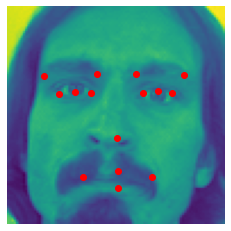

In [203]:
idx = 0

preds = nn_model.predict(tf_input[idx][np.newaxis, :])

preds_xs = preds[:, np.argwhere(['_x' in l for l in labels])]
preds_ys = preds[:, np.argwhere(['_y' in l for l in labels])]

plt.imshow(tf_input[idx])
plt.scatter(preds_xs[0], preds_ys[0], color='r')
plt.axis('off')
plt.show()

In [205]:
nn_model.save('./tmp/model_cbl')

INFO:tensorflow:Assets written to: ./tmp/model_cbl/assets
